Autores:

Angie Lorena Pineda Morales

Juan David De Los RIos Mahecha

# **Comparación del Rendimiento de Tres Métodos para Resolver Sistemas Tridiagonales en la Ecuación de Poisson usando Python, C y Fortran**

# **Una dimensión**

En esta primera parte se aborda la solución numérica de la **ecuación de Poisson unidimensional** mediante el método de diferencias finitas. Se considera el siguiente problema con condiciones de frontera tipo Dirichlet:

$$
\frac{d^2 u}{dx^2} = f(x), \quad u(0) = u(1) = 0
$$

donde el término fuente está definido como:

$$
f(x) = -\pi^2 \cos(\pi x)
$$

y la solución exacta correspondiente es:

$$
u(x) = \cos(\pi x) + 2x - 1
$$


Este problema se discretiza utilizando diferencias finitas centradas, lo que conduce a un sistema lineal tridiagonal. Dicho sistema se resuelve mediante tres métodos numéricos clásicos: **Thomas**, **Jacobi** y **Gauss-Seidel**.

El objetivo principal de este cuaderno es verificar la precisión de los métodos numéricos comparando sus soluciones con la solución analítica; y por otro, **comparar el rendimiento computacional** de cada método al ser implementado en tres lenguajes de programación: **Python, C y Fortran**. Para ello, se miden y analizan los tiempos de ejecución con el fin de evaluar la eficiencia.






# Python


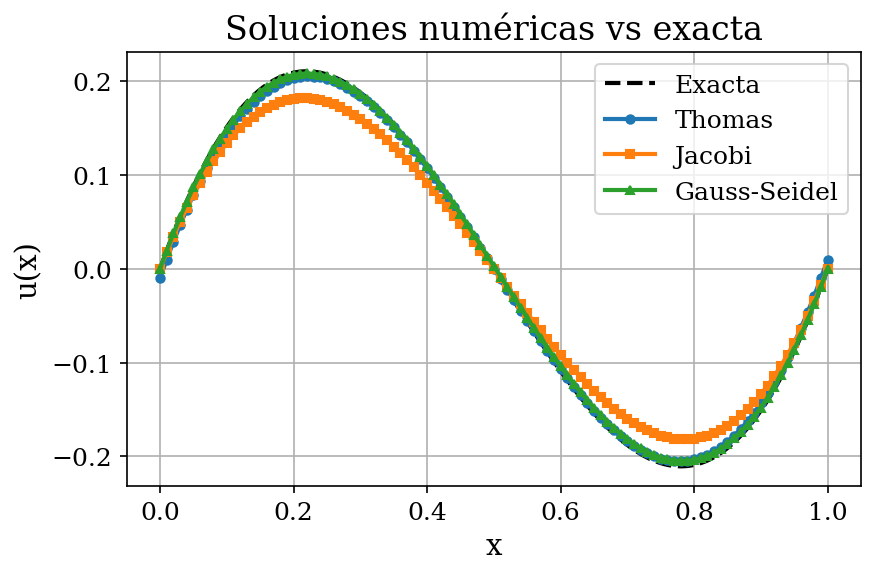

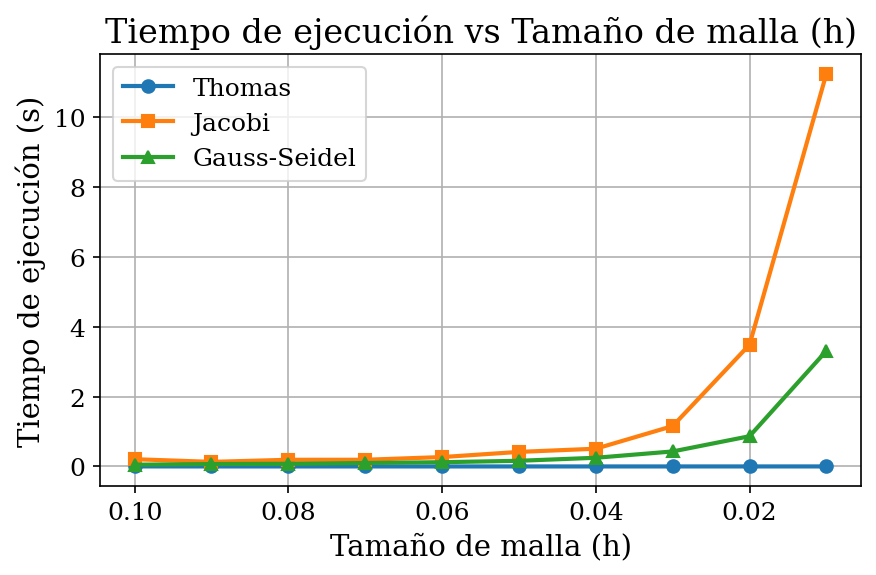

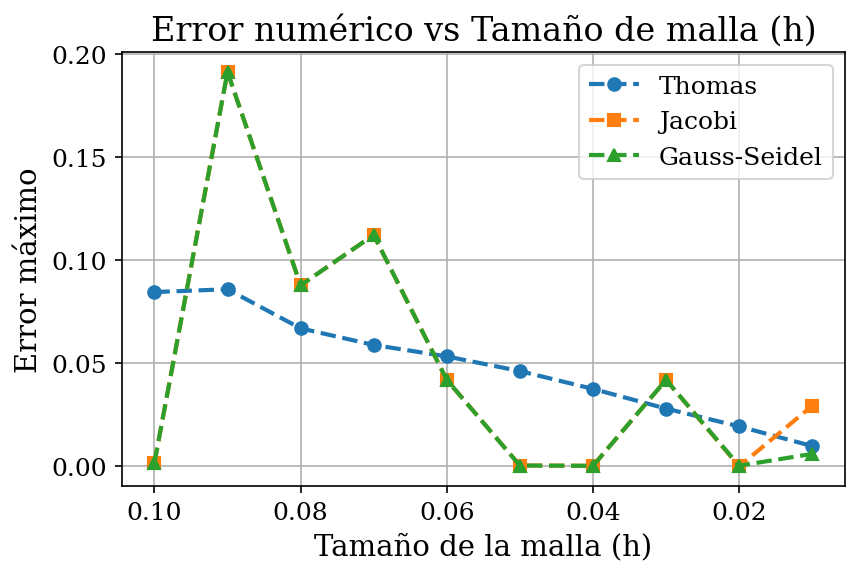

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Estilo
plt.rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "lines.linewidth": 2,
    "figure.dpi": 150
})

# Fuente y solución exacta
def f(x): return -np.pi**2 * np.cos(np.pi * x)
def u_exacta(x): return np.cos(np.pi * x) + 2 * x - 1

# Método de Thomas
def thomas_solver(a, b, c, d):
    n = len(d)
    c_ = np.zeros(n); d_ = np.zeros(n); x = np.zeros(n) #Inicialización de los arreglos
    c_[0] = c[0] / b[0]; d_[0] = d[0] / b[0]
    for i in range(1, n):
        denom = b[i] - a[i]*c_[i-1]
        c_[i] = c[i] / denom if i < n-1 else 0 #Eliminación hacia adelante (Forward Sweep)
        d_[i] = (d[i] - a[i]*d_[i-1]) / denom
    x[-1] = d_[-1]                          #Sustitución hacia atrás (Backward Substitution)
    for i in range(n-2, -1, -1):
        x[i] = d_[i] - c_[i] * x[i+1]
    return x

# Jacobi
def jacobi_solver(A, b, x0=None, iter=1000):
    n = len(b); x = np.zeros(n) if x0 is None else x0.copy() #Propocionar una suposición que este de 0 a 1.
    for _ in range(iter):
        x_new = np.zeros_like(x)
        for i in range(n):  #Realizar el primer x y luego siga iterando
            s = sum(A[i,j]*x[j] for j in range(n) if j != i)
            x_new[i] = (b[i] - s) / A[i,i]
        x = x_new
    return x

# Gauss-Seidel
def gs_solver(A, b, x0=None, iter=1000):
    n = len(b); x = np.zeros(n) if x0 is None else x0.copy() #Propocionar una suposición que este de 0 a 1.
    for _ in range(iter):
        for i in range(n):
            s1 = sum(A[i,j]*x[j] for j in range(i))         #Calcula respecto a las variables ya actualizadas
            s2 = sum(A[i,j]*x[j] for j in range(i+1, n))
            x[i] = (b[i] - s1 - s2) / A[i,i]
    return x

# Resolver
def solve(h, metodo="thomas"):
    x = np.arange(0, 1+h, h) #Esta diseñado solo para resolver en 1D, esto primero define la construccion de la malla
    N = len(x)
    a = np.ones(N); b = -2*np.ones(N); c = np.ones(N)  #Define los coeficientes a, b, c del sistema tridiagonal correspondiente a la ecuación discretizada.
    d = h**2 * f(x)
    a[0] = c[-1] = 0; b[0] = b[-1] = 1; d[0] = d[-1] = 0 #Fija las condiciones de frontera homogéneas
    if metodo == "thomas":
        return x, thomas_solver(a, b, c, d)
    A = np.zeros((N, N))
    for i in range(1, N-1):
        A[i,i-1] = A[i,i+1] = 1
        A[i,i] = -2
    A[0,0] = A[-1,-1] = 1
    if metodo == "jacobi":
        return x, jacobi_solver(A, d)
    elif metodo == "gs":
        return x, gs_solver(A, d)

# Métodos y parámetros
hs = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
metodos = ["thomas", "jacobi", "gs"]
labels = {"thomas": "Thomas", "jacobi": "Jacobi", "gs": "Gauss-Seidel"}
colores = {"thomas": "tab:blue", "jacobi": "tab:orange", "gs": "tab:green"}
marcadores = {"thomas": "o", "jacobi": "s", "gs": "^"}

tiempos = {m: [] for m in metodos}
errores = {m: [] for m in metodos}

# Recolectar datos
for metodo in metodos:
    for h in hs:
        t0 = time.perf_counter()
        x, u_aprox = solve(h, metodo)
        t1 = time.perf_counter()
        u_real = u_exacta(x)
        error = np.max(np.abs(u_aprox - u_real))
        tiempos[metodo].append(t1 - t0)
        errores[metodo].append(error)

# 1. Soluciones superpuestas
plt.figure(figsize=(6, 4))
x_fino = np.linspace(0, 1, 200)
plt.plot(x_fino, u_exacta(x_fino), '--k', label='Exacta')
for metodo in metodos:
    x, u_aprox = solve(hs[-1], metodo)
    plt.plot(x, u_aprox, label=labels[metodo], marker=marcadores[metodo],
             linestyle='-', color=colores[metodo], markersize=4)
plt.xlabel("x"); plt.ylabel("u(x)")
plt.title("Soluciones numéricas vs exacta")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
for metodo in metodos:
    plt.plot(hs, tiempos[metodo], marker=marcadores[metodo], color=colores[metodo], label=labels[metodo])

plt.gca().invert_xaxis()
plt.xlabel("Tamaño de malla (h)")
plt.ylabel("Tiempo de ejecución (s)")
plt.title("Tiempo de ejecución vs Tamaño de malla (h)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3. Error vs h
plt.figure(figsize=(6, 4))
for metodo in metodos:
    plt.plot(hs, errores[metodo], marker=marcadores[metodo], linestyle='--',
             color=colores[metodo], label=labels[metodo])
plt.gca().invert_xaxis()
plt.xlabel("Tamaño de la malla (h)")
plt.ylabel("Error máximo")
plt.title("Error numérico vs Tamaño de malla (h)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
for metodo in metodos:
    print(f"Tiempos de ejecución para {labels[metodo]}:")
    print(tiempos[metodo])


Tiempos de ejecución para Thomas:
[0.00111870299997463, 0.00010615899998356326, 9.985399998413413e-05, 0.00037390800002867763, 8.937100000139253e-05, 9.489800004303106e-05, 0.00015029799999410898, 0.00014594199996054158, 0.00024368399999730173, 0.00038250000000061846]
Tiempos de ejecución para Jacobi:
[0.20730850399996825, 0.13109257200000002, 0.19077065700003004, 0.19120435600001429, 0.26856137300001137, 0.416735607000021, 0.5079254030000016, 1.156813977000013, 3.4889751619999743, 11.253540748000034]
Tiempos de ejecución para Gauss-Seidel:
[0.05004822299997613, 0.06830565300003855, 0.07586238699997239, 0.09849259300000313, 0.12158156899999994, 0.16195420199994714, 0.2484849489999874, 0.4296641250000448, 0.8660744179999824, 3.3123582380000016]


# C


In [ ]:
%%writefile comparacion_metodos.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <string.h>
#include <time.h>

#define MAXN 1000
#define PI 3.141592653589793

// Funcion exacta y fuente
double u_exacta(double x) {
    return cos(PI * x) + 2 * x - 1;
}

double f(double x) {
    return -PI * PI * cos(PI * x);
}

// Metodo de Thomas
void thomas(int n, double *a, double *b, double *c, double *d, double *x) { // Declaración del algoritmo, donde a,b y c pertenecen a las diagonales
    double *c_ = malloc(n * sizeof(double));
    double *d_ = malloc(n * sizeof(double));
    c_[0] = c[0] / b[0];
    d_[0] = d[0] / b[0];
    for (int i = 1; i < n; i++) {           // Eliminación hacia adelante
        double denom = b[i] - a[i] * c_[i - 1];
        c_[i] = (i < n - 1) ? c[i] / denom : 0.0;
        d_[i] = (d[i] - a[i] * d_[i - 1]) / denom;
    }
    x[n - 1] = d_[n - 1];                 // Sustitución hacia atras
    for (int i = n - 2; i >= 0; i--) {
        x[i] = d_[i] - c_[i] * x[i + 1];
    }
    free(c_); free(d_);
}

// Metodo Jacobi
void jacobi(int n, double **A, double *b, double *x, int iter) {
    double *x_new = calloc(n, sizeof(double));
    for (int it = 0; it < iter; it++) { // Recalcula todas las variables basadas en los valores de la iteración anterior (almacenados en x)
        for (int i = 0; i < n; i++) {
            double s = 0.0;
            for (int j = 0; j < n; j++)
                if (j != i) s += A[i][j] * x[j];
            x_new[i] = (b[i] - s) / A[i][i];
        }
        for (int i = 0; i < n; i++) x[i] = x_new[i];
    }
    free(x_new);
}

// Metodo Gauss-Seidel
void gauss_seidel(int n, double **A, double *b, double *x, int iter) {
    for (int it = 0; it < iter; it++) {
        for (int i = 0; i < n; i++) {
            double s1 = 0.0, s2 = 0.0;
            for (int j = 0; j < i; j++) s1 += A[i][j] * x[j];
            for (int j = i + 1; j < n; j++) s2 += A[i][j] * x[j];
            x[i] = (b[i] - s1 - s2) / A[i][i];
        }
    }
}

void solve(char *metodo, double h, FILE *fout) {
    int N = (int)(1.0 / h) + 1;
    double x[MAXN], u[MAXN], u_real[MAXN];
    double a[MAXN], b[MAXN], c[MAXN], d[MAXN];

    for (int i = 0; i < N; i++) {
        x[i] = i * h;
        d[i] = h * h * f(x[i]);
        a[i] = 1.0; b[i] = -2.0; c[i] = 1.0;
    }

    b[0] = b[N - 1] = 1.0;
    d[0] = d[N - 1] = 0.0;
    a[0] = c[N - 1] = 0.0;

    clock_t start = clock();

    if (strcmp(metodo, "thomas") == 0) {
        thomas(N, a, b, c, d, u);
    } else {
        double **A = malloc(N * sizeof(double*));
        for (int i = 0; i < N; i++) A[i] = calloc(N, sizeof(double));
        for (int i = 1; i < N - 1; i++) {
            A[i][i - 1] = A[i][i + 1] = 1.0;
            A[i][i] = -2.0;
        }
        A[0][0] = A[N - 1][N - 1] = 1.0;

        if (strcmp(metodo, "jacobi") == 0)
            jacobi(N, A, d, u, 1000);
        else
            gauss_seidel(N, A, d, u, 1000);

        for (int i = 0; i < N; i++) free(A[i]);
        free(A);
    }

    clock_t end = clock();
    double tiempo = (double)(end - start) / CLOCKS_PER_SEC;

    double err_max = 0.0;
    for (int i = 0; i < N; i++) {
        u_real[i] = u_exacta(x[i]);
        double err = fabs(u[i] - u_real[i]);
        if (err > err_max) err_max = err;
    }

    fprintf(fout, "%f,%f,%f\n", h, tiempo, err_max);
}

int main() {
    double hs[] = {0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01};
    int nh = sizeof(hs) / sizeof(hs[0]);
    char *metodos[] = {"thomas", "jacobi", "gs"};

    for (int m = 0; m < 3; m++) {
        char fname[50];
        sprintf(fname, "%s_FR_resultados.csv", metodos[m]);  // Nombre ajustado
        FILE *fout = fopen(fname, "w");
        fprintf(fout, "h,tiempo,error\n");
        for (int i = 0; i < nh; i++) {
            solve(metodos[m], hs[i], fout);
        }
        fclose(fout);
    }

    printf("Listo: se generaron archivos _FR_resultados.csv para cada metodo.\n");
    return 0;
}



Writing comparacion_metodos.c


In [ ]:
!gcc comparacion_metodos.c -o comparacion_metodos -lm

In [ ]:
!./comparacion_metodos


Listo: se generaron archivos _FR_resultados.csv para cada metodo.


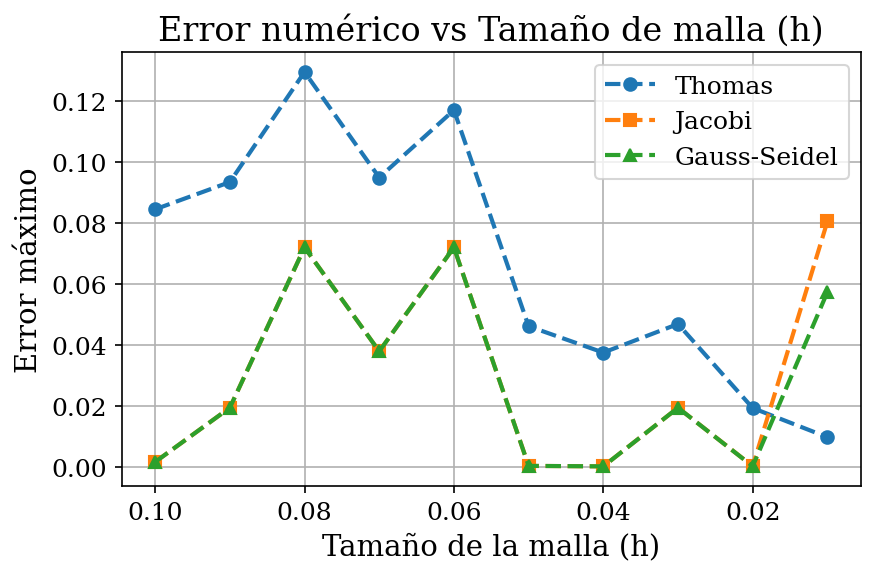

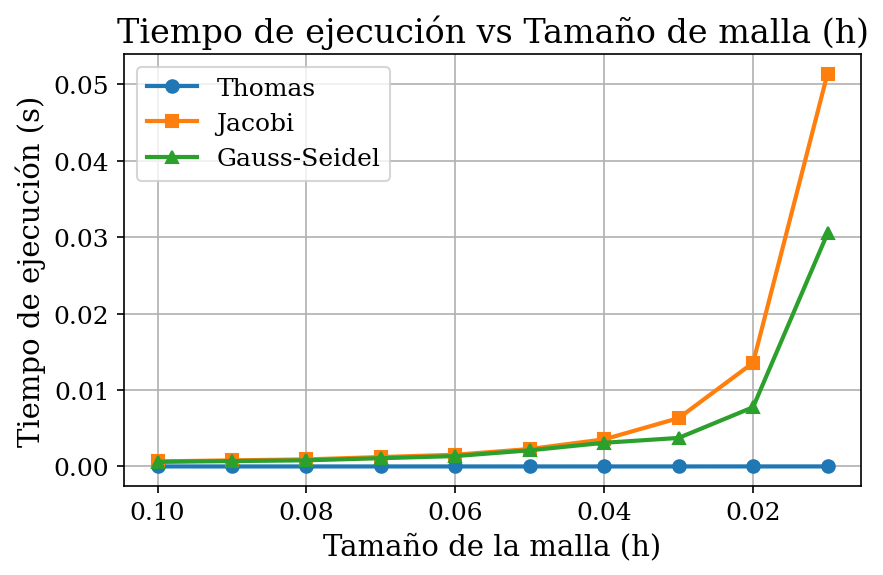

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Configuración de estilos
plt.rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "lines.linewidth": 2,
    "figure.dpi": 150
})

# Métodos y estilo
metodos = ["thomas", "jacobi", "gs"]
labels = {"thomas": "Thomas", "jacobi": "Jacobi", "gs": "Gauss-Seidel"}
colores = {"thomas": "tab:blue", "jacobi": "tab:orange", "gs": "tab:green"}
marcadores = {"thomas": "o", "jacobi": "s", "gs": "^"}

# Cargar datos
errores = {}
tiempos = {}
hs = None

for metodo in metodos:
    df = pd.read_csv(f"{metodo}_FR_resultados.csv")
    errores[metodo] = df["error"].to_numpy()
    tiempos[metodo] = df["tiempo"].to_numpy()
    if hs is None:
        hs = df["h"].to_numpy()

# Gráfica de errores
fig_err = plt.figure(figsize=(6, 4))
for metodo in metodos:
    plt.plot(hs, errores[metodo], marker=marcadores[metodo],
             linestyle='--', color=colores[metodo], label=labels[metodo])
plt.gca().invert_xaxis()
plt.xlabel("Tamaño de la malla (h)")
plt.ylabel("Error máximo")
plt.title("Error numérico vs Tamaño de malla (h)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfica de tiempos
fig_time = plt.figure(figsize=(6, 4))
for metodo in metodos:
    plt.plot(hs, tiempos[metodo], marker=marcadores[metodo],
             color=colores[metodo], label=labels[metodo])
plt.gca().invert_xaxis()
plt.xlabel("Tamaño de la malla (h)")
plt.ylabel("Tiempo de ejecución (s)")
plt.title("Tiempo de ejecución vs Tamaño de malla (h)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
for metodo in metodos:
    print(f"Tiempos de ejecución para {labels[metodo]}:")
    print(tiempos[metodo])

Tiempos de ejecución para Thomas:
[2.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-06 3.e-06]
Tiempos de ejecución para Jacobi:
[0.000658 0.000798 0.000924 0.001231 0.001532 0.002284 0.003549 0.006325
 0.013562 0.051405]
Tiempos de ejecución para Gauss-Seidel:
[0.000601 0.0007   0.000802 0.001079 0.001357 0.002111 0.003097 0.003732
 0.007754 0.030498]


# FORTRAN

In [ ]:
%%writefile comparacion_metodos_1D.f90
program comparacion_metodos
    implicit none
    integer, parameter :: dp = selected_real_kind(15)
    integer :: i, j, it, nh, m, N, iter
    real(dp), dimension(10) :: hs = (/ 0.1_dp, 0.09_dp, 0.08_dp, 0.07_dp, 0.06_dp, 0.05_dp, 0.04_dp, 0.03_dp, 0.02_dp, 0.01_dp /)
    character(len=6), dimension(3) :: metodos
    character(len=30) :: fname ! Guarde el nombre de los metodos
    real(dp), allocatable :: x(:), u(:), ureal(:), a1(:), b1(:), c1(:), d1(:)
    real(dp), allocatable :: A(:,:), b(:)
    real(dp) :: start, finish, h, err, err_max
    integer :: unit

    metodos = (/ 'thomas', 'jacobi', 'gs    ' /)

    nh = size(hs)
    iter = 1000

    do m = 1, 3  ! Recorra los tres metodos
        write(fname, '(A,"_FR_resultados.csv")') trim(metodos(m))
        open(newunit=unit, file=fname, status='replace')
        write(unit,*) "h,tiempo,error"

        do i = 1, nh
            h = hs(i)
            N = int(1.0_dp / h) + 1
            allocate(x(N), u(N), ureal(N), a1(N), b1(N), c1(N), d1(N))

            ! Armar malla y RHS
            do j = 1, N
                x(j) = (j-1) * h
                d1(j) = h * h * f(x(j))
                a1(j) = 1.0_dp
                b1(j) = -2.0_dp
                c1(j) = 1.0_dp
            end do

            ! Condiciones de frontera
            b1(1) = 1.0_dp; b1(N) = 1.0_dp
            d1(1) = 0.0_dp; d1(N) = 0.0_dp
            a1(1) = 0.0_dp; c1(N) = 0.0_dp

            call cpu_time(start) ! Medición del tiempo

            if (trim(metodos(m)) == 'thomas') then
                call thomas(N, a1, b1, c1, d1, u)
            else
                allocate(A(N,N), b(N))
                A = 0.0_dp
                b = d1
                do j = 2, N-1
                    A(j,j-1) = 1.0_dp
                    A(j,j)   = -2.0_dp
                    A(j,j+1) = 1.0_dp
                end do
                A(1,1) = 1.0_dp
                A(N,N) = 1.0_dp

                if (trim(metodos(m)) == 'jacobi') then
                    call jacobi(N, A, b, u, iter)
                else
                    call gauss_seidel(N, A, b, u, iter)
                end if

                deallocate(A, b)
            end if

            call cpu_time(finish)

            err_max = 0.0_dp
            do j = 1, N
                ureal(j) = u_exacta(x(j))
                err = abs(u(j) - ureal(j))
                if (err > err_max) err_max = err
            end do

            write(unit,'(F10.5,",",F10.5,",",E12.5)') h, finish - start, err_max
            deallocate(x, u, ureal, a1, b1, c1, d1)
        end do

        close(unit)
    end do

    print *, "Listo: se generaron archivos .csv con prefijo FR para cada método."
contains

    function u_exacta(x) result(u)
        real(dp), intent(in) :: x
        real(dp) :: u
        u = cos(acos(-1.0_dp) * x) + 2.0_dp * x - 1.0_dp
    end function

    function f(x) result(r)
        real(dp), intent(in) :: x
        real(dp) :: r
        r = -acos(-1.0_dp)**2 * cos(acos(-1.0_dp) * x)
    end function

    subroutine thomas(n, a, b, c, d, x)
        integer, intent(in) :: n
        real(dp), intent(in) :: a(n), b(n), c(n), d(n)
        real(dp), intent(out) :: x(n)
        real(dp), allocatable :: c_(:), d_(:)
        integer :: i
        allocate(c_(n), d_(n))
        c_(1) = c(1) / b(1)
        d_(1) = d(1) / b(1)
        do i = 2, n
            c_(i) = merge(c(i)/ (b(i) - a(i)*c_(i-1)), 0.0_dp, i < n)
            d_(i) = (d(i) - a(i) * d_(i-1)) / (b(i) - a(i) * c_(i-1))
        end do
        x(n) = d_(n)
        do i = n-1, 1, -1
            x(i) = d_(i) - c_(i) * x(i+1)
        end do
        deallocate(c_, d_)
    end subroutine

    subroutine jacobi(n, A, b, x, iter)
        integer, intent(in) :: n, iter
        real(dp), intent(in) :: A(n,n), b(n)
        real(dp), intent(out) :: x(n)
        real(dp), allocatable :: x_new(:)
        integer :: i, j, it
        allocate(x_new(n))
        x = 0.0_dp
        do it = 1, iter
            do i = 1, n
                x_new(i) = (b(i) - sum(A(i,:)*x(:)) + A(i,i)*x(i)) / A(i,i)
            end do
            x = x_new
        end do
        deallocate(x_new)
    end subroutine

    subroutine gauss_seidel(n, A, b, x, iter)
        integer, intent(in) :: n, iter
        real(dp), intent(in) :: A(n,n), b(n)
        real(dp), intent(out) :: x(n)
        integer :: i, j, it
        real(dp) :: sum1, sum2
        x = 0.0_dp
        do it = 1, iter
            do i = 1, n
                sum1 = 0.0_dp
                sum2 = 0.0_dp
                do j = 1, i-1
                    sum1 = sum1 + A(i,j)*x(j)
                end do
                do j = i+1, n
                    sum2 = sum2 + A(i,j)*x(j)
                end do
                x(i) = (b(i) - sum1 - sum2) / A(i,i)
            end do
        end do
    end subroutine

end program



Writing comparacion_metodos_1D.f90


# **Dos dimensiones**

En esta sección, se aborda la solución numérica de la ecuación en dos dimensiones mediante el método de diferencias finitas para el caso de un problema de Poisson. Consideramos las siguientes condiciones para el problema con frontera de Dirichlet:

$$
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f(x, y), \quad u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 0
$$

donde el término fuente está dado por:

$$
f(x, y) = -2 \pi^2 \sin(\pi x) \sin(\pi y)
$$

y la solución exacta correspondiente es:

$$
u(x, y) = \sin(\pi x) \sin(\pi y)
$$

Este problema se discretiza usando el método de diferencias finitas, resultando en un sistema lineal que se resuelve utilizando los métodos iterativos clásicos **Jacobi** y **Gauss-Seidel**. La solución aproximada se obtiene mediante la iteración sucesiva de estos métodos hasta alcanzar una tolerancia de error predefinida.

El propósito principal de este estudio es comparar la precisión de los métodos numéricos al comparar las soluciones obtenidas con la solución exacta y analizar el rendimiento computacional de ambos métodos. Para ello, se lleva a cabo una evaluación de los tiempos de ejecución para cada método, con el fin de identificar cuál es más eficiente en términos de recursos computacionales. Los resultados de los métodos se obtienen en función de distintos valores de la resolución espacial \( h \), y se comparan tanto en términos de precisión como de tiempo de ejecución.


# Python

Procesando método Jacobi...
h=0.100, error=8.26e-03, tiempo=0.0048 s
h=0.090, error=2.47e-01, tiempo=0.0072 s
h=0.080, error=1.25e-01, tiempo=0.0088 s
h=0.070, error=1.56e-01, tiempo=0.0116 s
h=0.060, error=6.27e-02, tiempo=0.0158 s
h=0.050, error=1.56e-01, tiempo=0.0251 s
h=0.040, error=1.25e-01, tiempo=0.0255 s
h=0.030, error=6.28e-02, tiempo=0.0295 s
h=0.020, error=1.29e-01, tiempo=0.0418 s
h=0.010, error=6.10e-01, tiempo=0.1067 s
Procesando método Gauss-Seidel...
h=0.100, error=8.26e-03, tiempo=0.0165 s
h=0.090, error=2.47e-01, tiempo=0.0321 s
h=0.080, error=1.25e-01, tiempo=0.0454 s
h=0.070, error=1.56e-01, tiempo=0.0882 s
h=0.060, error=6.27e-02, tiempo=0.1446 s
h=0.050, error=1.56e-01, tiempo=0.3311 s
h=0.040, error=1.25e-01, tiempo=0.7643 s
h=0.030, error=6.28e-02, tiempo=1.4901 s
h=0.020, error=6.28e-02, tiempo=3.2854 s
h=0.010, error=3.73e-01, tiempo=13.6132 s


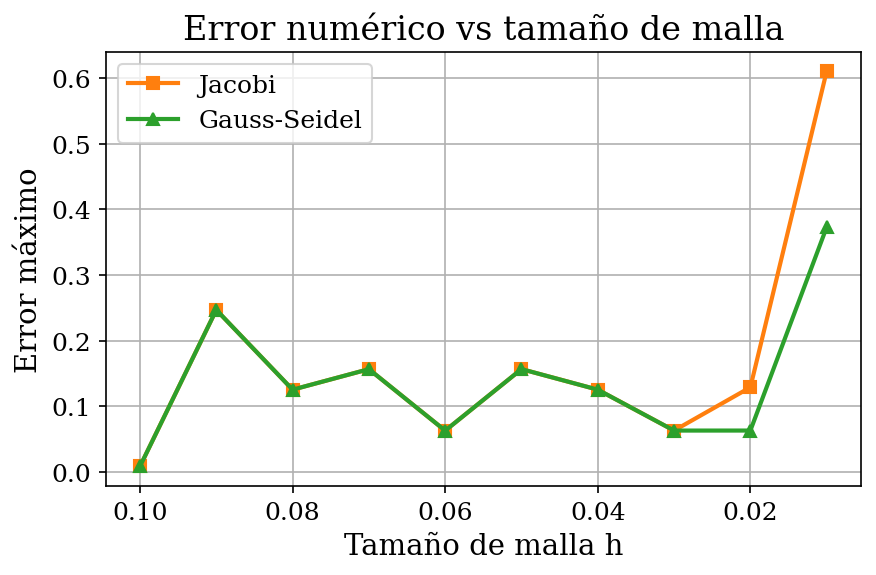

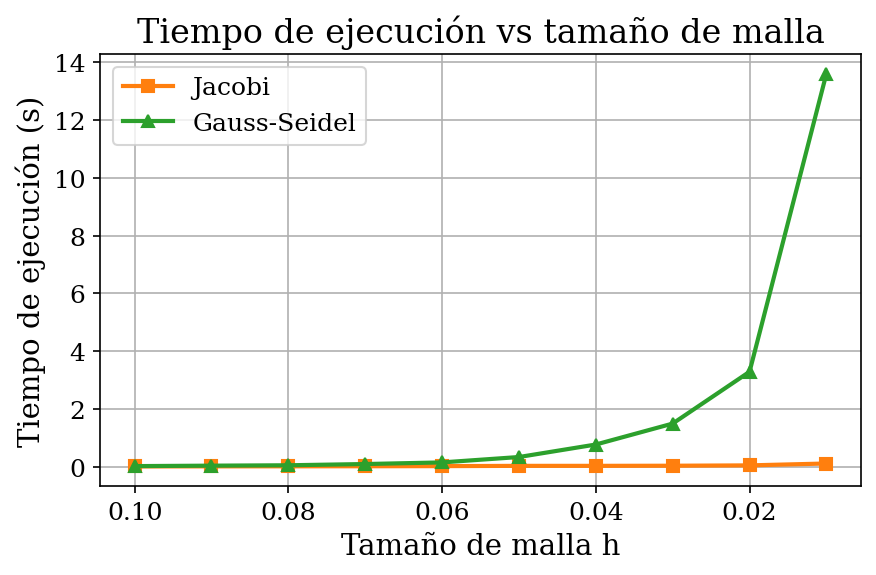

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Funciones analítica y fuente
def u_exacta(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def f(x, y):
    return -2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)

# Método Jacobi
def jacobi_2d(f, u0, h, max_iter=1000, tol=1e-6):
    u = u0.copy()
    n = u.shape[0] - 2
    for it in range(max_iter):
        u_new = u.copy()
        u_new[1:-1,1:-1] = 0.25 * (u[2:,1:-1] + u[:-2,1:-1] + u[1:-1,2:] + u[1:-1,:-2] - h**2 * f[1:-1,1:-1])
        if np.linalg.norm(u_new - u, ord=np.inf) < tol:
            break
        u = u_new
    return u

# Método Gauss-Seidel
def gs_2d(f, u0, h, max_iter=1000, tol=1e-6):
    u = u0.copy()
    n = u.shape[0] - 2
    for it in range(max_iter):
        u_old = u.copy()
        for i in range(1, n+1):
            for j in range(1, n+1):
                u[i,j] = 0.25 * (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] - h**2 * f[i,j])
        if np.linalg.norm(u - u_old, ord=np.inf) < tol:
            break
    return u

# Función para resolver y registrar tiempo y error
def solve_and_measure(h, metodo):
    x = np.arange(0, 1+h, h)
    y = np.arange(0, 1+h, h)
    X, Y = np.meshgrid(x, y)
    u0 = np.zeros_like(X)
    F = f(X, Y)

    start_time = time.time()
    if metodo == "jacobi":
        u_num = jacobi_2d(F, u0, h)
    elif metodo == "gs":
        u_num = gs_2d(F, u0, h)
    elapsed_time = time.time() - start_time

    u_ex = u_exacta(X, Y)
    err = np.max(np.abs(u_num - u_ex))

    return err, elapsed_time

# Parámetros
metodos = ["jacobi", "gs"]
labels = {"jacobi": "Jacobi", "gs": "Gauss-Seidel"}
colores = {"jacobi": "tab:orange", "gs": "tab:green"}
marcadores = {"jacobi": "s", "gs": "^"}
hs = np.linspace(0.1, 0.01, 10)

# Guardar resultados
errores = {m: [] for m in metodos}
tiempos = {m: [] for m in metodos}

for metodo in metodos:
    print(f"Procesando método {labels[metodo]}...")
    for h in hs:
        err, t = solve_and_measure(h, metodo)
        errores[metodo].append(err)
        tiempos[metodo].append(t)
        print(f"h={h:.3f}, error={err:.2e}, tiempo={t:.4f} s")

# Convertir a numpy arrays
for metodo in metodos:
    errores[metodo] = np.array(errores[metodo])
    tiempos[metodo] = np.array(tiempos[metodo])

# Gráfica de Errores
plt.figure(figsize=(6, 4))
for metodo in metodos:
    plt.plot(hs, errores[metodo], marker=marcadores[metodo], color=colores[metodo], label=labels[metodo])
plt.gca().invert_xaxis()
plt.xlabel("Tamaño de malla h")
plt.ylabel("Error máximo")
plt.title("Error numérico vs tamaño de malla")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfica de Tiempos
plt.figure(figsize=(6, 4))
for metodo in metodos:
    plt.plot(hs, tiempos[metodo], marker=marcadores[metodo], color=colores[metodo], label=labels[metodo])
plt.gca().invert_xaxis()
plt.xlabel("Tamaño de malla h")
plt.ylabel("Tiempo de ejecución (s)")
plt.title("Tiempo de ejecución vs tamaño de malla")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



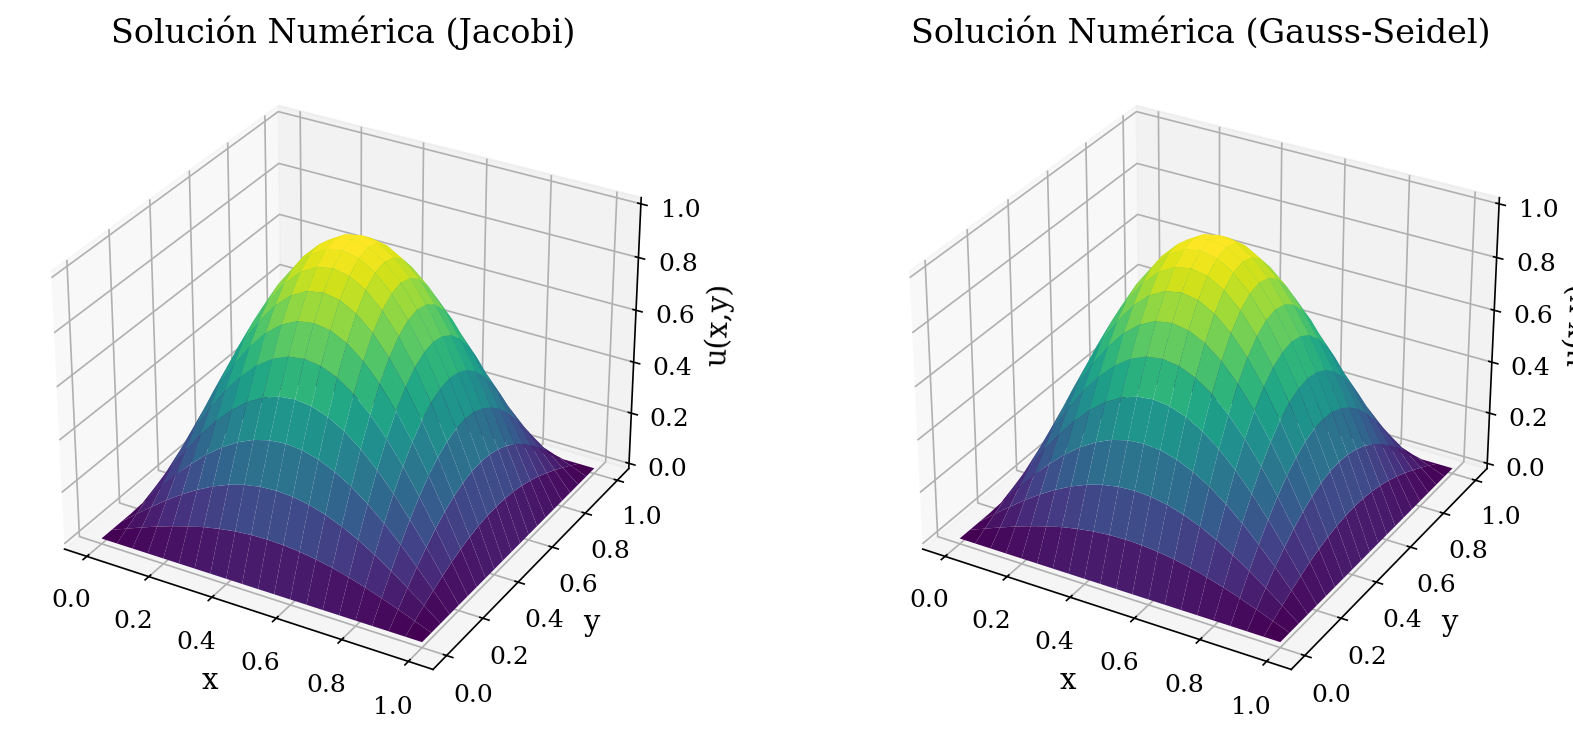

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Necesario para gráficos 3D

# Elegimos un valor de h representativo
h_viz = 0.05
x = np.arange(0, 1 + h_viz, h_viz)
y = np.arange(0, 1 + h_viz, h_viz)
X, Y = np.meshgrid(x, y)
u0 = np.zeros_like(X)
F = f(X, Y)

# Graficar soluciones en 3D
fig = plt.figure(figsize=(12, 5))

for i, metodo in enumerate(metodos):
    if metodo == "jacobi":
        u_sol = jacobi_2d(F, u0, h_viz)
    elif metodo == "gs":
        u_sol = gs_2d(F, u0, h_viz)

    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    surf = ax.plot_surface(X, Y, u_sol, cmap='viridis', edgecolor='none')
    ax.set_title(f"Solución Numérica ({labels[metodo]})")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("u(x,y)")

fig.tight_layout()
plt.show()


# C

In [ ]:
%%writefile comparacion_metodos_2D.c
#include <stdio.h>
#include <math.h>
#include <stdlib.h>
#include <time.h>

// Funciones analítica y fuente
double u_exacta(double x, double y) {
    return sin(M_PI * x) * sin(M_PI * y);
}

double f(double x, double y) {
    return -2 * M_PI * M_PI * sin(M_PI * x) * sin(M_PI * y);
}

// Método de Jacobi
void jacobi_2d(double **f, double **u, double h, int n, int max_iter, double tol) {
    double **u_new = (double**)malloc((n+2) * sizeof(double*));
    for (int i = 0; i < n + 2; i++) {
        u_new[i] = (double*)malloc((n+2) * sizeof(double));
    }

    for (int it = 0; it < max_iter; it++) {
        for (int i = 1; i <= n; i++) {
            for (int j = 1; j <= n; j++) {
                u_new[i][j] = 0.25 * (u[i+1][j] + u[i-1][j] + u[i][j+1] + u[i][j-1] - h*h*f[i][j]);
            }
        }

        double max_diff = 0.0;
        for (int i = 1; i <= n; i++) {
            for (int j = 1; j <= n; j++) {
                max_diff = fmax(max_diff, fabs(u_new[i][j] - u[i][j]));
            }
        }

        if (max_diff < tol) {
            break;
        }

        for (int i = 1; i <= n; i++) {
            for (int j = 1; j <= n; j++) {
                u[i][j] = u_new[i][j];
            }
        }
    }

    for (int i = 0; i < n + 2; i++) {
        free(u_new[i]);
    }
    free(u_new);
}

// Método de Gauss-Seidel
void gs_2d(double **f, double **u, double h, int n, int max_iter, double tol) {
    for (int it = 0; it < max_iter; it++) {
        double max_diff = 0.0;
        for (int i = 1; i <= n; i++) {
            for (int j = 1; j <= n; j++) {
                double u_old = u[i][j];
                u[i][j] = 0.25 * (u[i+1][j] + u[i-1][j] + u[i][j+1] + u[i][j-1] - h*h*f[i][j]);
                max_diff = fmax(max_diff, fabs(u[i][j] - u_old));
            }
        }

        if (max_diff < tol) {
            break;
        }
    }
}

// Rutina general
void solve_2d(double h, void (*metodo)(double**, double**, double, int, int, double), char *filename, int n, FILE *time_file, char *method_name) {
    double **u = (double**)malloc((n+2) * sizeof(double*));
    double **f_matrix = (double**)malloc((n+2) * sizeof(double*));

    for (int i = 0; i < n + 2; i++) {
        u[i] = (double*)malloc((n+2) * sizeof(double));
        f_matrix[i] = (double*)malloc((n+2) * sizeof(double));
    }

    for (int i = 0; i < n + 2; i++) {
        for (int j = 0; j < n + 2; j++) {
            double x = i * h;
            double y = j * h;
            u[i][j] = 0.0;
            f_matrix[i][j] = f(x, y);
        }
    }

    // Medir tiempo de ejecución
    clock_t start_time = clock();
    metodo(f_matrix, u, h, n, 1000, 1e-6);  // Tolerancia ajustada a 1e-6
    clock_t end_time = clock();

    double time_taken = ((double)(end_time - start_time)) / CLOCKS_PER_SEC;
    fprintf(time_file, "%s, %.2f, %f\n", method_name, h, time_taken);

    FILE *file = fopen(filename, "w");
    for (int i = 1; i <= n; i++) {
        for (int j = 1; j <= n; j++) {
            fprintf(file, "%f", u[i][j]);
            if (j < n) {
                fprintf(file, ",");
            }
        }
        fprintf(file, "\n");
    }
    fclose(file);

    for (int i = 0; i < n + 2; i++) {
        free(u[i]);
        free(f_matrix[i]);
    }
    free(u);
    free(f_matrix);
}

int main() {
    double hs[] = {0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01};
    int num_hs = sizeof(hs) / sizeof(hs[0]);

    // Archivo para los tiempos de ejecución
    FILE *time_file = fopen("tiempos.csv", "w");
    fprintf(time_file, "Metodo,h,Tiempo(s)\n");

    for (int i = 0; i < num_hs; i++) {
        int n = (int)(1.0 / hs[i]) - 1;

        char filename_jacobi[50];
        char filename_gs[50];

        sprintf(filename_jacobi, "C2D_jacobi_h%.2f.csv", hs[i]);
        sprintf(filename_gs, "C2D_gs_h%.2f.csv", hs[i]);

        solve_2d(hs[i], jacobi_2d, filename_jacobi, n, time_file, "Jacobi");
        solve_2d(hs[i], gs_2d, filename_gs, n, time_file, "Gauss-Seidel");
    }

    fclose(time_file);

    return 0;
}



Writing comparacion_metodos_2D.c


In [ ]:
!gcc comparacion_metodos_2D.c -o comparacion_metodos_2D -lm

In [ ]:
!./comparacion_metodos_2D

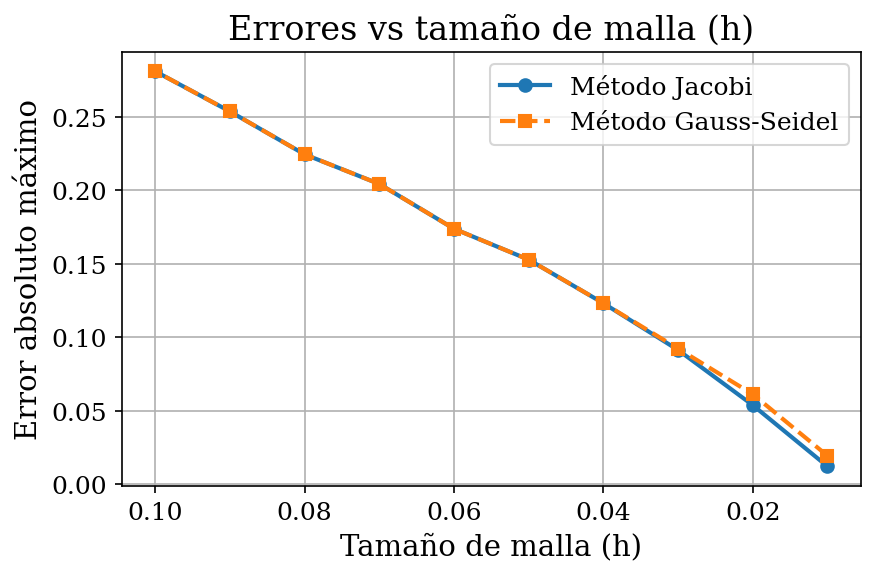

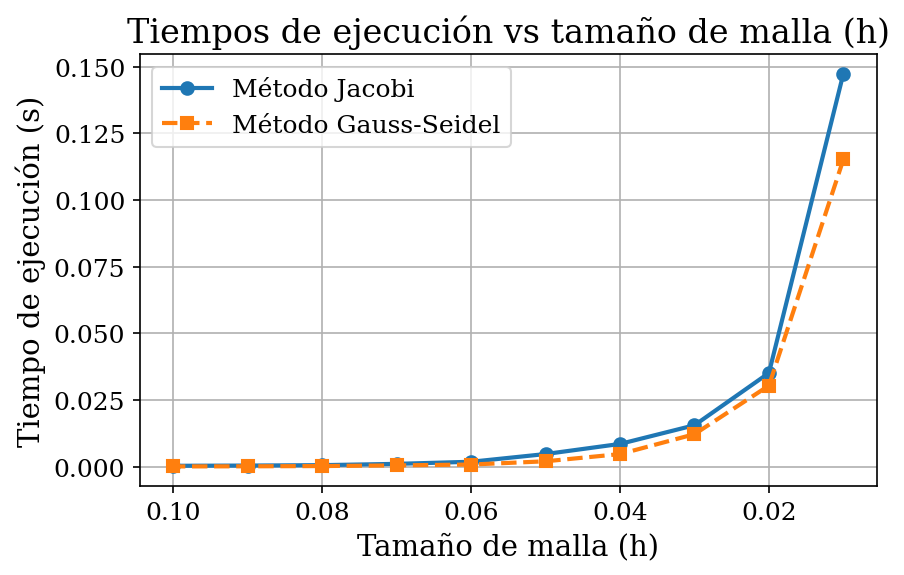

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Leer el archivo de tiempos correctamente como tabla con cabeceras
df = pd.read_csv("tiempos.csv")

# Obtener valores únicos de h
hs = sorted(df['h'].unique(), reverse=False)

# Inicializar listas para almacenar los tiempos
tiempos_jacobi = []
tiempos_gs = []

# Extraer los tiempos por cada h
for h in hs:
    tiempo_jacobi = df[(df['Metodo'] == 'Jacobi') & (df['h'] == h)]['Tiempo(s)'].values[0]
    tiempo_gs = df[(df['Metodo'] == 'Gauss-Seidel') & (df['h'] == h)]['Tiempo(s)'].values[0]
    tiempos_jacobi.append(tiempo_jacobi)
    tiempos_gs.append(tiempo_gs)

# Convertir a numpy arrays
hs = np.array(hs)
tiempos_jacobi = np.array(tiempos_jacobi)
tiempos_gs = np.array(tiempos_gs)

# Errores (debes tener los archivos correspondientes)
errores_jacobi = []
errores_gs = []

def calcular_error(n, h, archivo):
    try:
        datos = np.loadtxt(archivo, delimiter=",")
        error = np.max(np.abs(datos[:, 0] - datos[:, 1]))
        return error
    except Exception as e:
        print(f"Error al leer {archivo}: {e}")
        return np.nan

for h in hs:
    n = int(1.0 / h) - 1
    archivo_jacobi = f"C2D_jacobi_h{h:.2f}.csv"
    archivo_gs = f"C2D_gs_h{h:.2f}.csv"
    errores_jacobi.append(calcular_error(n, h, archivo_jacobi))
    errores_gs.append(calcular_error(n, h, archivo_gs))

errores_jacobi = np.array(errores_jacobi)
errores_gs = np.array(errores_gs)
# Definir colores y estilos manualmente
colores = {"jacobi": "tab:orange", "gs": "tab:green"}
marcadores = {"jacobi": "o", "gs": "s"}


# Graficar errores
plt.figure(figsize=(6, 4))
plt.plot(hs, errores_jacobi, label="Método Jacobi", marker='o', linestyle='-')
plt.plot(hs, errores_gs, label="Método Gauss-Seidel", marker='s', linestyle='--')
plt.gca().invert_xaxis()
plt.xlabel('Tamaño de malla (h)')
plt.ylabel('Error absoluto máximo')
plt.title('Errores vs tamaño de malla (h)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Graficar tiempos
plt.figure(figsize=(6, 4))
plt.plot(hs, tiempos_jacobi, label="Método Jacobi", marker='o', linestyle='-')
plt.plot(hs, tiempos_gs, label="Método Gauss-Seidel", marker='s', linestyle='--')
plt.gca().invert_xaxis()
plt.xlabel('Tamaño de malla (h)')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Tiempos de ejecución vs tamaño de malla (h)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()



In [ ]:
!gfortran -O2 -o comparacion_metodos comparacion_metodos_1D.f90

In [ ]:
!./comparacion_metodos

 Listo: se generaron archivos .csv con prefijo FR para cada método.


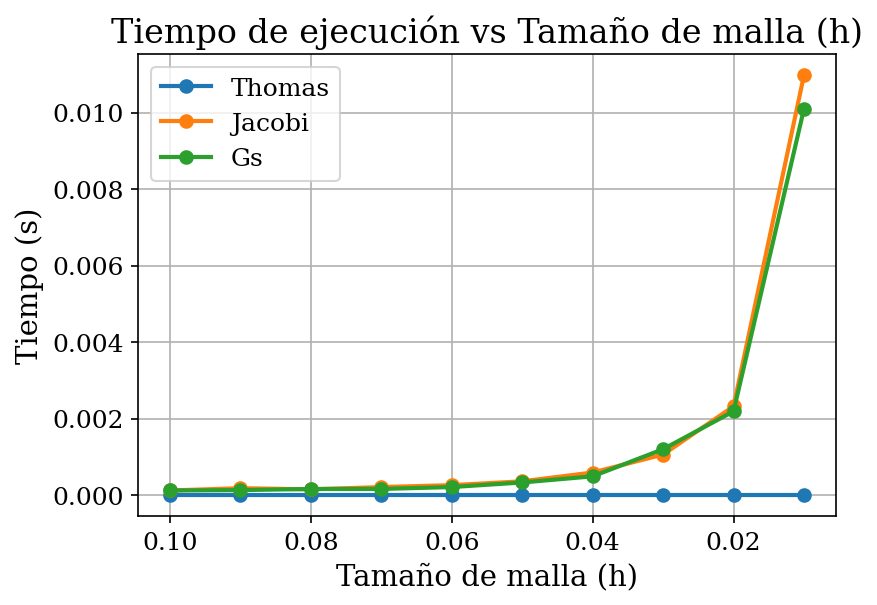

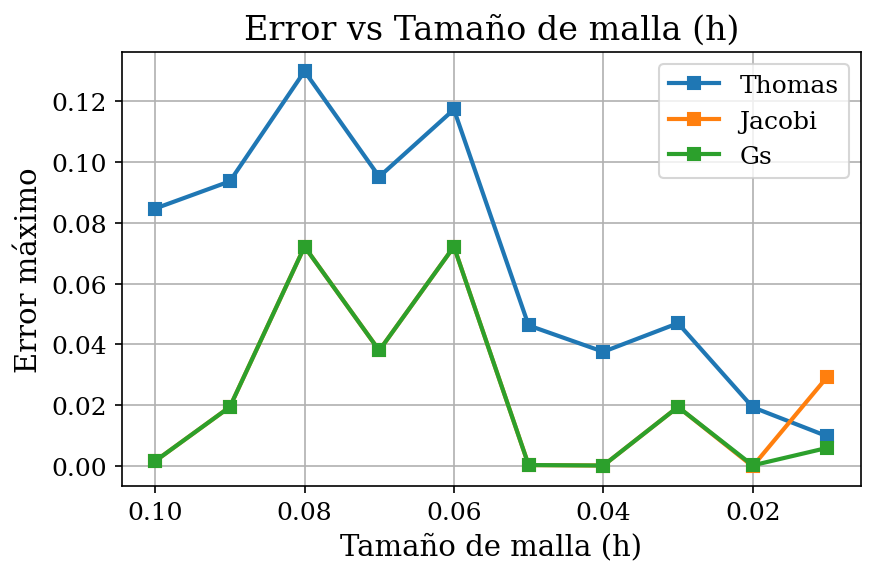

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Configuración de estilos
plt.rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "lines.linewidth": 2,
    "figure.dpi": 150
})

# Métodos y estilo
metodos = ['thomas', 'jacobi', 'gs']
archivos = [f'{m}_FR_resultados.csv' for m in metodos]
colores = {"thomas": "tab:blue", "jacobi": "tab:orange", "gs": "tab:green"}

# Subgráfico 1: Tiempo vs h
plt.figure(figsize=(6, 4))
for archivo, metodo in zip(archivos, metodos):
    df = pd.read_csv(archivo, skiprows=1, header=None, names=['h', 'tiempo', 'error'])
    plt.plot(df['h'], df['tiempo'], marker='o', label=metodo.capitalize(), color=colores[metodo])
plt.xlabel('Tamaño de malla (h)')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo de ejecución vs Tamaño de malla (h)')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()  # Invertir eje x

# Subgráfico 2: Error vs h
plt.figure(figsize=(6, 4))
for archivo, metodo in zip(archivos, metodos):
    df = pd.read_csv(archivo, skiprows=1, header=None, names=['h', 'tiempo', 'error'])
    plt.plot(df['h'], df['error'], marker='s', label=metodo.capitalize(), color=colores[metodo])
plt.xlabel('Tamaño de malla (h)')
plt.ylabel('Error máximo')
plt.title('Error vs Tamaño de malla (h)')
plt.grid(True)
plt.legend()
plt.gca().invert_xaxis()  # Invertir eje x

plt.tight_layout()
plt.show()


In [ ]:
for metodo in metodos:
    print(f"Tiempos de ejecución para {labels[metodo]}:")
    print(tiempos[metodo])


Tiempos de ejecución para Thomas:
[2.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 1.e-06 3.e-06 3.e-06]
Tiempos de ejecución para Jacobi:
[0.000658 0.000798 0.000924 0.001231 0.001532 0.002284 0.003549 0.006325
 0.013562 0.051405]
Tiempos de ejecución para Gauss-Seidel:
[0.000601 0.0007   0.000802 0.001079 0.001357 0.002111 0.003097 0.003732
 0.007754 0.030498]


# FORTRAN

In [ ]:
%%writefile FR2D_comparison_methods_2D.c
#include <stdio.h>
#include <math.h>
#include <stdlib.h>
#include <time.h>

// Funciones analítica y fuente
double u_exacta(double x, double y) {
    return sin(M_PI * x) * sin(M_PI * y);
}

double f(double x, double y) {
    return -2 * M_PI * M_PI * sin(M_PI * x) * sin(M_PI * y);
}

// Método de Jacobi
void jacobi_2d(double **f, double **u, double h, int n, int max_iter, double tol) {
    double **u_new = (double**)malloc((n+2) * sizeof(double*));
    for (int i = 0; i < n + 2; i++) {
        u_new[i] = (double*)malloc((n+2) * sizeof(double));
    }

    for (int it = 0; it < max_iter; it++) {
        for (int i = 1; i <= n; i++) {
            for (int j = 1; j <= n; j++) {
                u_new[i][j] = 0.25 * (u[i+1][j] + u[i-1][j] + u[i][j+1] + u[i][j-1] - h*h*f[i][j]);
            }
        }

        double max_diff = 0.0;
        for (int i = 1; i <= n; i++) {
            for (int j = 1; j <= n; j++) {
                max_diff = fmax(max_diff, fabs(u_new[i][j] - u[i][j]));
            }
        }

        if (max_diff < tol) {
            break;
        }

        for (int i = 1; i <= n; i++) {
            for (int j = 1; j <= n; j++) {
                u[i][j] = u_new[i][j];
            }
        }
    }

    for (int i = 0; i < n + 2; i++) {
        free(u_new[i]);
    }
    free(u_new);
}

// Método de Gauss-Seidel
void gs_2d(double **f, double **u, double h, int n, int max_iter, double tol) {
    for (int it = 0; it < max_iter; it++) {
        double max_diff = 0.0;
        for (int i = 1; i <= n; i++) {
            for (int j = 1; j <= n; j++) {
                double u_old = u[i][j];
                u[i][j] = 0.25 * (u[i+1][j] + u[i-1][j] + u[i][j+1] + u[i][j-1] - h*h*f[i][j]);
                max_diff = fmax(max_diff, fabs(u[i][j] - u_old));
            }
        }

        if (max_diff < tol) {
            break;
        }
    }
}

// Rutina general
void solve_2d(double h, void (*metodo)(double**, double**, double, int, int, double), char *filename, int n, FILE *time_file, char *method_name) {
    double **u = (double**)malloc((n+2) * sizeof(double*));
    double **f_matrix = (double**)malloc((n+2) * sizeof(double*));

    for (int i = 0; i < n + 2; i++) {
        u[i] = (double*)malloc((n+2) * sizeof(double));
        f_matrix[i] = (double*)malloc((n+2) * sizeof(double));
    }

    for (int i = 0; i < n + 2; i++) {
        for (int j = 0; j < n + 2; j++) {
            double x = i * h;
            double y = j * h;
            u[i][j] = 0.0;
            f_matrix[i][j] = f(x, y);
        }
    }

    // Medir tiempo de ejecución
    clock_t start_time = clock();
    metodo(f_matrix, u, h, n, 1000, 1e-8);
    clock_t end_time = clock();

    double time_taken = ((double)(end_time - start_time)) / CLOCKS_PER_SEC;
    fprintf(time_file, "%s, %.2f, %f\n", method_name, h, time_taken);

    FILE *file = fopen(filename, "w");
    for (int i = 1; i <= n; i++) {
        for (int j = 1; j <= n; j++) {
            fprintf(file, "%f", u[i][j]);
            if (j < n) {
                fprintf(file, ",");
            }
        }
        fprintf(file, "\n");
    }
    fclose(file);

    for (int i = 0; i < n + 2; i++) {
        free(u[i]);
        free(f_matrix[i]);
    }
    free(u);
    free(f_matrix);
}

int main() {
    double hs[] = {0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01};
    int num_hs = sizeof(hs) / sizeof(hs[0]);

    // Archivo para los tiempos de ejecución
    FILE *time_file = fopen("tiempos.csv", "w");
    fprintf(time_file, "Metodo,h,Tiempo(s)\n");

    for (int i = 0; i < num_hs; i++) {
        int n = (int)(1.0 / hs[i]) - 1;

        char filename_jacobi[50];
        char filename_gs[50];

        sprintf(filename_jacobi, "FR2D_jacobi_h%.2f.csv", hs[i]);
        sprintf(filename_gs, "FR2D_gs_h%.2f.csv", hs[i]);

        solve_2d(hs[i], jacobi_2d, filename_jacobi, n, time_file, "Jacobi");
        solve_2d(hs[i], gs_2d, filename_gs, n, time_file, "Gauss-Seidel");
    }

    fclose(time_file);

    return 0;
}


Writing FR2D_comparison_methods_2D.c


In [ ]:
!gfortran -O2 -o FR2D_comparison_methods_2D FR2D_comparison_methods_2D.c

In [ ]:
!./FR2D_comparison_methods_2D

Procesando método Jacobi...
h=0.100, error=8.27e-03, tiempo=0.0065 s
h=0.090, error=2.47e-01, tiempo=0.0094 s
h=0.080, error=1.25e-01, tiempo=0.0115 s
h=0.070, error=1.56e-01, tiempo=0.0151 s
h=0.060, error=6.27e-02, tiempo=0.0201 s
h=0.050, error=1.56e-01, tiempo=0.0219 s
h=0.040, error=1.25e-01, tiempo=0.0264 s
h=0.030, error=6.28e-02, tiempo=0.0304 s
h=0.020, error=1.29e-01, tiempo=0.0413 s
h=0.010, error=6.10e-01, tiempo=0.0947 s
Procesando método Gauss-Seidel...
h=0.100, error=8.27e-03, tiempo=0.0224 s
h=0.090, error=2.47e-01, tiempo=0.0451 s
h=0.080, error=1.25e-01, tiempo=0.0616 s
h=0.070, error=1.56e-01, tiempo=0.1314 s
h=0.060, error=6.27e-02, tiempo=0.1811 s
h=0.050, error=1.56e-01, tiempo=0.4085 s
h=0.040, error=1.25e-01, tiempo=0.8787 s
h=0.030, error=6.28e-02, tiempo=1.5303 s
h=0.020, error=6.28e-02, tiempo=3.2536 s
h=0.010, error=3.73e-01, tiempo=14.6321 s


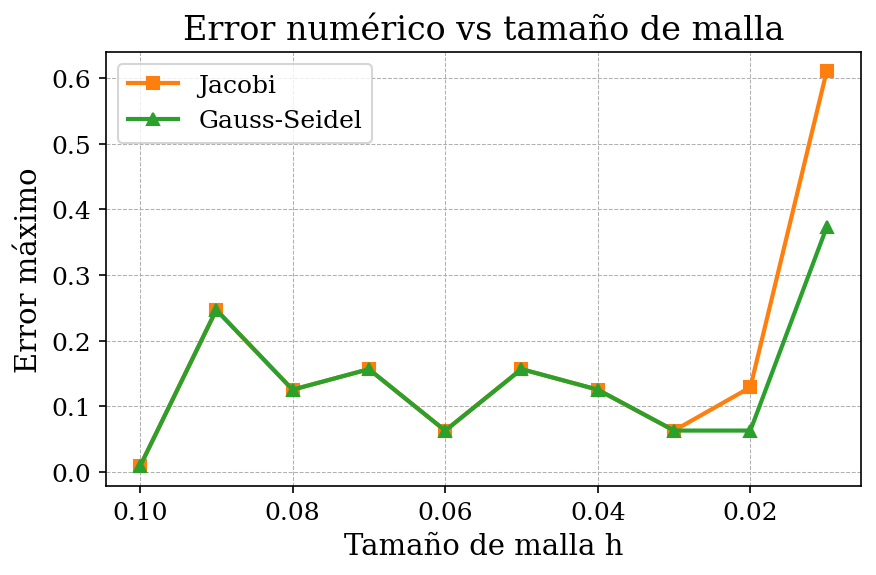

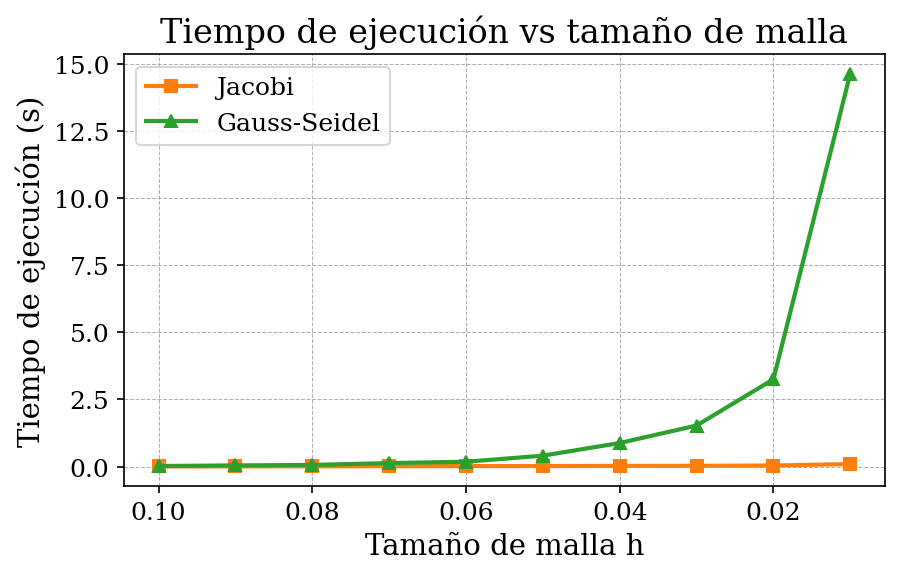

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Funciones analítica y fuente
def u_exacta(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)

def f(x, y):
    return -2 * np.pi**2 * np.sin(np.pi * x) * np.sin(np.pi * y)

# Método Jacobi
def jacobi_2d(f, u0, h, max_iter=1000, tol=1e-8):
    u = u0.copy()
    n = u.shape[0] - 2
    for it in range(max_iter):
        u_new = u.copy()
        u_new[1:-1,1:-1] = 0.25 * (u[2:,1:-1] + u[:-2,1:-1] + u[1:-1,2:] + u[1:-1,:-2] - h**2 * f[1:-1,1:-1])
        if np.linalg.norm(u_new - u, ord=np.inf) < tol:
            break
        u = u_new
    return u

# Método Gauss-Seidel
def gs_2d(f, u0, h, max_iter=1000, tol=1e-8):
    u = u0.copy()
    n = u.shape[0] - 2
    for it in range(max_iter):
        u_old = u.copy()
        for i in range(1, n+1):
            for j in range(1, n+1):
                u[i,j] = 0.25 * (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] - h**2 * f[i,j])
        if np.linalg.norm(u - u_old, ord=np.inf) < tol:
            break
    return u

# Función para resolver y registrar tiempo y error
def solve_and_measure(h, metodo):
    x = np.arange(0, 1+h, h)
    y = np.arange(0, 1+h, h)
    X, Y = np.meshgrid(x, y)
    u0 = np.zeros_like(X)
    F = f(X, Y)

    start_time = time.time()
    if metodo == "jacobi":
        u_num = jacobi_2d(F, u0, h)
    elif metodo == "gs":
        u_num = gs_2d(F, u0, h)
    elapsed_time = time.time() - start_time

    u_ex = u_exacta(X, Y)
    err = np.max(np.abs(u_num - u_ex))

    return err, elapsed_time

# Parámetros
metodos = ["jacobi", "gs"]
labels = {"jacobi": "Jacobi", "gs": "Gauss-Seidel"}
colores = {"jacobi": "tab:orange", "gs": "tab:green"}
marcadores = {"jacobi": "s", "gs": "^"}
hs = np.linspace(0.1, 0.01, 10)

# Guardar resultados
errores = {m: [] for m in metodos}
tiempos = {m: [] for m in metodos}

for metodo in metodos:
    print(f"Procesando método {labels[metodo]}...")
    for h in hs:
        err, t = solve_and_measure(h, metodo)
        errores[metodo].append(err)
        tiempos[metodo].append(t)
        print(f"h={h:.3f}, error={err:.2e}, tiempo={t:.4f} s")

# Convertir a numpy arrays
for metodo in metodos:
    errores[metodo] = np.array(errores[metodo])
    tiempos[metodo] = np.array(tiempos[metodo])

# Gráfica de Errores
plt.figure(figsize=(6, 4))
for metodo in metodos:
    plt.plot(hs, errores[metodo], marker=marcadores[metodo], color=colores[metodo], label=labels[metodo])
plt.gca().invert_xaxis()
plt.xlabel("Tamaño de malla h")
plt.ylabel("Error máximo")
plt.title("Error numérico vs tamaño de malla")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Gráfica de Tiempos
plt.figure(figsize=(6, 4))
for metodo in metodos:
    plt.plot(hs, tiempos[metodo], marker=marcadores[metodo], color=colores[metodo], label=labels[metodo])
plt.gca().invert_xaxis()
plt.xlabel("Tamaño de malla h")
plt.ylabel("Tiempo de ejecución (s)")
plt.title("Tiempo de ejecución vs tamaño de malla")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()



# **SEGUNDA PARTE**

## Discretización de las PDE

- Consideremos como ejemplo la ecuación de Poisson en 2D:

$$
\nabla^2 \phi(\vec{r}) = -4\pi \rho(\vec{r})
$$

- con una placa rectangular hueca y condiciones de borde de Dirichlet en los bordes externos e internos.

- Definimos una red de puntos que cubre la región de interés en el plano \( (x, y) \) de ancho fijo \( h \).

- Finalmente, para las derivadas usamos elementos finitos:

$$
\nabla^2 \phi(\vec{r}) = \frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} = \frac{\phi_{i+1,j} + \phi_{i-1,j} - 2\phi_{i,j}}{h^2} + \frac{\phi_{i,j+1} + \phi_{i,j-1} - 2\phi_{i,j}}{h^2}
$$

- Entonces la PDE se transforma en:

$$
\phi_{i+1,j} + \phi_{i-1,j} + \phi_{i,j+1} + \phi_{i,j-1} - 4\phi_{i,j} = -4\pi h^2 \rho_{i,j}
$$

- Que se puede escribir en forma matricial:

$$
\mathcal{M} \Phi = \mathcal{S}
$$


- En cualquier caso, las condiciones de contorno proporcionarán los valores de \( \phi_{i,j} \) en algún subconjunto de puntos de la red.



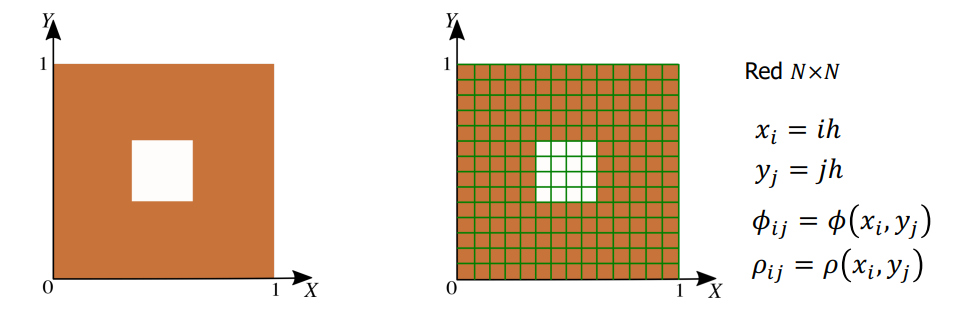

In [5]:
%%writefile poisson_solver.f90
!Calcula la ecuación de Poisson en un sistema bidimensional rectangular
PROGRAM Poisson2D
  implicit none
  real(8),parameter::PI=3.141592653589793d0
  integer::Nx,Ny
  real(8),allocatable::phi(:,:),rho(:,:)
  real(8)::Vx1,Vx2,Vy1,Vy2,Q,eps,Lx,Ly,h,area,rho0
  logical,allocatable::conductor(:,:)

  !datos del problema
  write(6,*)'tamaño de la placa rectangular (Lx Ly) en metros?'
  read(5,*)Lx,Ly
  if(Lx.le.Ly)then
     write(6,*)'número de puntos en la grilla en la direccion X?'
     read(5,*)Nx
  else
     write(6,*)'número de puntos en la grilla en la direccionYX?'
     read(5,*)Ny
  end if
  write(6,*)'potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios'
  read(5,*)Vx1,Vx2,Vy1,Vy2
  write(6,*)'carga (Q) en Coulumbs?'
  read(5,*)Q
  write(6,*)'presición en la convergencia para la relajación'
  read(5,*)eps

  !informacion de la grilla y localiza memoria
  if(Lx.le.Ly)then
     h=Lx/Nx; Ny=int(Ly/h)
  else
     h=Ly/Ny; Nx=int(Lx/h)
  end if
  write(6,*)
  write(6,"(a,i4,'  X ',i4)")'puntos en la grilla: ',Nx,Ny
  allocate(phi(0:Nx,0:Ny),rho(0:Nx,0:Ny),conductor(0:Nx,0:Ny))
  phi=0.d0; rho=0.d0
  area=Lx*Ly
  rho0=Q/area
  rho0=rho0*PI*h**2

  !inicializa la red
  call red_inicial(Vx1,Vx2,Vy1,Vy2,Nx,Ny,rho0,conductor,rho,phi)

  !calcula la ecuacion de Poisson iterativamente (Gauss-Seidel)
  call Poisson(Nx,Ny,eps,conductor,rho,phi)

  !guarda resultados
  call guardar(Nx,Ny,h,phi)

END PROGRAM Poisson2D

!****************************************************************
SUBROUTINE red_inicial(Vx1,Vx2,Vy1,Vy2,Nx,Ny,rho0,conductor,rho,phi)
  implicit none
  integer,INTENT(IN)::Nx,Ny
  real(8),INTENT(IN)::Vx1,Vx2,Vy1,Vy2,rho0
  real(8),dimension(0:Nx,0:Ny),INTENT(OUT)::rho,phi
  logical,dimension(0:Nx,0:Ny),INTENT(OUT)::conductor
  integer::i,j,i1,i2,j1,j2

  !inicia la red con valores 0 and .FALSE.
  phi=0.d0
  conductor=.FALSE.
  rho=0.d0
  !ponemos las condiciones de frontera (conductores)
  conductor(:,0)=.TRUE.  !lado inferior del rectangulo
  conductor(:,Ny)=.TRUE. !lado superior del rectangulo
  conductor(0,:)=.TRUE.  !lado izquierdo del rectangulo
  conductor(Nx,:)=.TRUE. !lado derecho del rectangulo
  phi(:,0)=Vx1
  phi(:,Ny)=Vx2
  phi(0,:)=Vy1
  phi(Nx,:)=Vy2

  !distribucion uniforme de carga en el interior
  do i=1,Nx-1
     do j=1,Ny-1
        rho(i,j)=rho0
     enddo
  enddo

  ! Hueco cuadrado centrado en el dominio
  i1 = Nx/2 - Nx/8
  i2 = Nx/2 + Nx/8
  j1 = Ny/2 - Ny/8
  j2 = Ny/2 + Ny/8
  do i = i1, i2
     do j = j1, j2
        conductor(i,j) = .TRUE.
        phi(i,j) = 0.0d0
     end do
  end do
END SUBROUTINE red_inicial

!****************************************************************
SUBROUTINE Poisson(Nx,Ny,eps,conductor,rho,phi)
  implicit none
  integer,INTENT(IN)::Nx,Ny
  real(8),INTENT(IN)::eps
  logical,dimension(0:Nx,0:Ny),INTENT(IN)::conductor
  real(8),dimension(0:Nx,0:Ny),INTENT(INOUT)::rho,phi
  integer::i,j,iconteo
  real(8)::phi_ij,error,dphi

  iconteo=0
  do while (.TRUE.)
     error=0.d0
     do i=1,Nx-1
        do j=1,Ny-1
           !cambiamos el potencial solo para no conductores
           if(.NOT.conductor(i,j))then
              phi_ij=0.25d0*(phi(i+1,j)+phi(i-1,j)+phi(i,j+1)+phi(i,j-1))+ &
                   rho(i,j)
              dphi=abs(phi(i,j)-phi_ij)
              if(error.lt.dphi)error=dphi !error maximo
              phi(i,j)=phi_ij
           endif
        enddo
     enddo
     iconteo=iconteo+1
     if(error.lt.eps)exit
  enddo
  write(6,*)iconteo,' error= ',error

END SUBROUTINE Poisson

!****************************************************************
SUBROUTINE guardar(Nx,Ny,h,phi)
  implicit none
  integer,INTENT(IN)::Nx,Ny
  real(8),INTENT(IN)::h
  real(8),dimension(0:Nx,0:Ny),INTENT(IN)::phi
  integer::i,j,n
  real(8)::x,y,V0,v0p,vxy,a,b,pi

  !Solucion analitica para el caso Q=0 con condiciones 0 V0 0 0
  V0=200.d0
  pi=3.141592653589793d0
  v0p=4.d0*V0/pi
  a=Nx*h; b=Ny*h
  !!!!!!!!

  open(unit=1,file="data_poisson")
  do i=0,Nx
     do j=0,Ny

        !Solucion analitica para el caso Q=0 con condiciones 0 V0 0 0
        x=i*h; y=j*h; vxy=0.d0
        do n=1,50,2
           vxy=vxy+sin(n*pi*x/b)*sinh(n*pi*y/a)/(n*sinh(n*pi*a/b))
        end do
        vxy=vxy*v0
        !!!!!!!!!!!!

        write(1,"(2(F10.5,1x),2(F15.7,1x))")i*h,j*h,phi(i,j),vxy
     enddo
     write(1,*)
  enddo

  write(6,*)'resultados en data_poisson'

END SUBROUTINE guardar

Overwriting poisson_solver.f90


In [6]:
!gfortran poisson_solver.f90 -o poisson_solver
!./poisson_solver


 tamaño de la placa rectangular (Lx Ly) en metros?
100
100
 número de puntos en la grilla en la direccion X?
50
 potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios
0
0
200
0
 carga (Q) en Coulumbs?
1e-6
 presición en la convergencia para la relajación
1e-5

puntos en la grilla:   50  X   50
         954  error=    9.9110872042729170E-006
 resultados en data_poisson


In [29]:
import numpy as np
import plotly.graph_objects as go

# Leer datos desde el archivo
with open("data_poisson") as f:
    lines = f.readlines()

x, y, v = [], [], []
for line in lines:
    if line.strip() == "":
        continue
    cols = line.strip().split()
    if len(cols) < 3:
        continue
    a, b, c = float(cols[0]), float(cols[1]), float(cols[2])
    x.append(a)
    y.append(b)
    v.append(c)

x = np.array(x)
y = np.array(y)
v = np.array(v)

# Determinar dimensiones
Nx = len(np.unique(x))
Ny = len(np.unique(y))
X = x.reshape(Nx, Ny)
Y = y.reshape(Nx, Ny)
V = v.reshape(Nx, Ny)

# Crear figura 3D interactiva
fig = go.Figure(data=[go.Surface(z=V, x=X, y=Y, colorscale='Plasma')])
fig.update_layout(
    title="Potencial eléctrico V(x, y)",
    scene=dict(
        xaxis_title='x (m)',
        yaxis_title='y (m)',
        zaxis_title='V(x,y)',
    ),
    width=800,
    height=600,
    margin=dict(l=50, r=50, b=50, t=50)
)
fig.show()

In [13]:
!chmod +x poisson_solver.f90

In [14]:
!./poisson_solver.f90


./poisson_solver.f90: line 1: !Calcula: command not found
./poisson_solver.f90: line 2: PROGRAM: command not found
./poisson_solver.f90: line 3: implicit: command not found
./poisson_solver.f90: line 4: syntax error near unexpected token `8'
./poisson_solver.f90: line 4: `  real(8),parameter::PI=3.141592653589793d0'


In [15]:
!gfortran poisson_solver.f90 -o poisson_solver


In [16]:
!./poisson_solver

 tamaño de la placa rectangular (Lx Ly) en metros?
100
100
 número de puntos en la grilla en la direccion X?
50
 potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios
0
0
200
0
 carga (Q) en Coulumbs?
1e-6
 presición en la convergencia para la relajación
1e-5

puntos en la grilla:   50  X   50
         954  error=    9.9110872042729170E-006
 resultados en data_poisson


In [32]:
!time ./poisson_solver

 tamaño de la placa rectangular (Lx Ly) en metros?
100
100
 número de puntos en la grilla en la direccion X?
50
 potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios
0
0
200
0
 carga (Q) en Coulumbs?
1e-6
 presición en la convergencia para la relajación
1e-5

puntos en la grilla:   50  X   50
         954  error=    9.9110872042729170E-006
 resultados en data_poisson

real	0m18.176s
user	0m0.034s
sys	0m0.002s


In [19]:
!time ./poisson_solver

 tamaño de la placa rectangular (Lx Ly) en metros?
100
100
 número de puntos en la grilla en la direccion X?
100
 potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios
0
0
200
0
 carga (Q) en Coulumbs?
1e-6
 presición en la convergencia para la relajación
1e-5

puntos en la grilla:  100  X  100
        3364  error=    9.9964447173306326E-006
 resultados en data_poisson

real	0m22.235s
user	0m0.378s
sys	0m0.003s


In [20]:
!time ./poisson_solver

 tamaño de la placa rectangular (Lx Ly) en metros?
100
100
 número de puntos en la grilla en la direccion X?
150
 potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios
0
0
200
0
 carga (Q) en Coulumbs?
1e-6
 presición en la convergencia para la relajación
1e-5

puntos en la grilla:  150  X  150
        6970  error=    9.9976349900998684E-006
 resultados en data_poisson

real	0m28.088s
user	0m1.819s
sys	0m0.003s


In [22]:
!time ./poisson_solver

 tamaño de la placa rectangular (Lx Ly) en metros?
100
100
 número de puntos en la grilla en la direccion X?
200
 potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios
0
0
200
0
 carga (Q) en Coulumbs?
1e-6
 presición en la convergencia para la relajación
1e-5

puntos en la grilla:  200  X  200
       11348  error=    9.9959210473343774E-006
 resultados en data_poisson

real	0m28.749s
user	0m5.581s
sys	0m0.007s


In [23]:
!time ./poisson_solver


 tamaño de la placa rectangular (Lx Ly) en metros?
100
100
 número de puntos en la grilla en la direccion X?
250
 potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios
0
0
200
0
 carga (Q) en Coulumbs?
1e-6
 presición en la convergencia para la relajación
1e-5

puntos en la grilla:  250  X  250

       16923  error=    9.9969207383310277E-006
 resultados en data_poisson

real	0m38.284s
user	0m15.448s
sys	0m0.022s


In [24]:
!time ./poisson_solver

 tamaño de la placa rectangular (Lx Ly) en metros?
100
100
 número de puntos en la grilla en la direccion X?
300
 potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios
0
0
200
0
 carga (Q) en Coulumbs?
1e-6
 presición en la convergencia para la relajación
1e-5

puntos en la grilla:  300  X  300

       23391  error=    9.9966813849050595E-006
 resultados en data_poisson

real	0m56.848s
user	0m32.559s
sys	0m0.031s


In [25]:
!time ./poisson_solver

 tamaño de la placa rectangular (Lx Ly) en metros?
100
100
 número de puntos en la grilla en la direccion X?
350
 potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios
0
0
200
0
 carga (Q) en Coulumbs?
1e-6
 presición en la convergencia para la relajación
1e-5

puntos en la grilla:  350  X  350
       30690  error=    9.9998708833481942E-006
 resultados en data_poisson

real	1m18.784s
user	0m54.356s
sys	0m0.044s


In [26]:
!time ./poisson_solver

 tamaño de la placa rectangular (Lx Ly) en metros?
100
100
 número de puntos en la grilla en la direccion X?
400
 potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios
0
0
200
0
 carga (Q) en Coulumbs?
1e-6
 presición en la convergencia para la relajación
1e-5

puntos en la grilla:  400  X  400
       38307  error=    9.9997265579077066E-006
 resultados en data_poisson

real	1m53.430s
user	1m33.009s
sys	0m0.067s


In [27]:
!time ./poisson_solver

 tamaño de la placa rectangular (Lx Ly) en metros?
100
100
 número de puntos en la grilla en la direccion X?
450
 potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios
0
0
200
0
 carga (Q) en Coulumbs?
1e-6
 presición en la convergencia para la relajación
1e-5

puntos en la grilla:  450  X  450
       47088  error=    9.9991748783168077E-006
 resultados en data_poisson

real	2m56.057s
user	2m28.431s
sys	0m0.104s


In [28]:
!time ./poisson_solver

 tamaño de la placa rectangular (Lx Ly) en metros?
100
100
 número de puntos en la grilla en la direccion X?
500
 potencial en las fronteras (Vx1 Vx2 Vy1 Vy2) en Voltios
0
0
200
0
 carga (Q) en Coulumbs?
1e-6
 presición en la convergencia para la relajación
1e-5

puntos en la grilla:  500  X  500
       56570  error=    9.9995504854177852E-006
 resultados en data_poisson

real	4m16.769s
user	3m54.887s
sys	0m0.167s


/home/angie/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


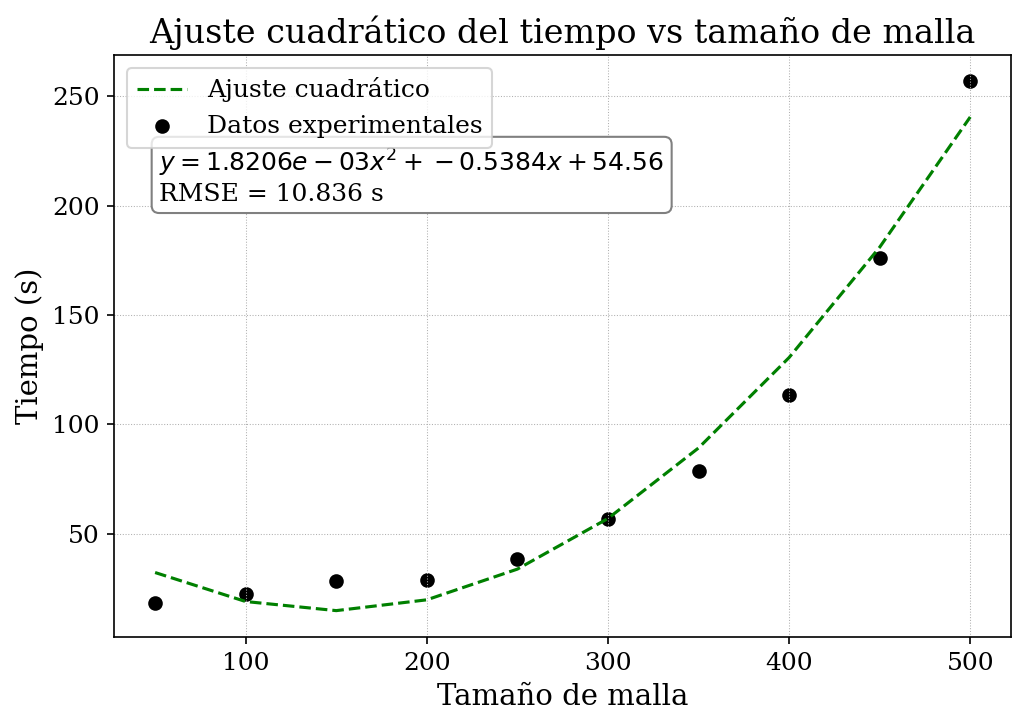

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Datos
mallas = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500]).reshape(-1, 1)
tiempos_real = np.array([18.176, 22.235, 28.088, 28.749, 38.284, 56.848, 78.784, 113.430, 176.057, 256.769])

# Regresión polinomial de segundo orden
poly = PolynomialFeatures(degree=2)
mallas_poly = poly.fit_transform(mallas)
reg = LinearRegression().fit(mallas_poly, tiempos_real)
tiempos_pred = reg.predict(mallas_poly)

# Coeficientes
a = reg.coef_[2]
b = reg.coef_[1]
c = reg.intercept_

# RMSE
rmse = np.sqrt(mean_squared_error(tiempos_real, tiempos_pred))

# Estilo tipo revista
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.dpi": 150,
    "axes.facecolor": "white"
})

# Crear figura
plt.figure(figsize=(7,5))
plt.plot(mallas, tiempos_pred, linestyle='--', color='green', label='Ajuste cuadrático')
plt.scatter(mallas, tiempos_real, color='black', label='Datos experimentales')

# Etiquetas y título
plt.xlabel('Tamaño de malla')
plt.ylabel('Tiempo (s)')
plt.title('Ajuste cuadrático del tiempo vs tamaño de malla')

# Mostrar ecuación y RMSE en el gráfico
eqn = f"$y = {a:.4e}x^2 + {b:.4f}x + {c:.2f}$\nRMSE = {rmse:.3f} s"
plt.text(0.05, 0.75, eqn, transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray'))

plt.legend()
plt.grid(True, linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

